In [44]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Malgun Gothic"

from sklearn.preprocessing import MinMaxScaler
from shapely import wkt
import folium
from folium import plugins
import sys
sys.path.append("../src/")

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [45]:
bnd = gpd.read_file(
    "../data/BND_ADM_DONG_PG/BND_ADM_DONG_PG.shp", 
    encoding="cp949"
    )

bnd = bnd[bnd["ADM_CD"].apply(lambda x: str(x)[0:2] == "38")]
bnd["ADM_CD"] = bnd["ADM_CD"].astype(str)
bnd["SGG_CD"] = bnd["ADM_CD"].apply(lambda x: x[0:5])

sgg_cd = [{
    "창원시 성산구" : '38112',
    "의령군" : '38510', 
    "창녕군" : '38530', 
    "고성군" : '38540', 
    "남해군" : '38550', 
    "하동군" : '38560', 
    "산청군" : '38570',
    "거창군" : '38590', 
    "합천군" : '38600', 
    "사천시" : '38060', 
    "양산시" : '38100', 
    "거제시" : '38090', 
    "김해시" : '38070', 
    "밀양시" : '38080',
    "창원시 진해구" : '38115', 
    "함양군" : '38580', 
    "창원시 의창구" : '38111', 
    "창원시 마산합포구" : '38113', 
    "창원시 마산회원구" : '38114', 
    "진주시" : '38030', 
    "통영시" : '38050',
    "함안군" : '38520'
    }]

sgg_cd = pd.DataFrame(sgg_cd).T.reset_index().rename(columns={"index" : "시군구명", 0 : "SGG_CD"})
bnd = pd.merge(bnd, sgg_cd, on="SGG_CD", how="left")
bnd = bnd.to_crs(crs="EPSG:5179")

## 노인 중심점 데이터
silver_index = pd.read_csv(
    filepath_or_buffer="../data/silver_index.csv"
)
threshold = silver_index["total_idx"].quantile(0.20)
silver_index_bot20 = silver_index[silver_index["total_idx"] <= threshold]
silver = pd.read_csv(
    filepath_or_buffer="../data/silver.csv"
).rename(columns={"gid" : "격자이름"})
silver_index_bot20 = pd.merge(left=silver_index_bot20[["격자이름", "total_idx"]], right=silver[["격자이름", "경도", "위도"]], on="격자이름", how="left")
silver_index_bot20 = gpd.GeoDataFrame(silver_index_bot20, geometry=gpd.points_from_xy(silver_index_bot20['경도'], silver_index_bot20['위도']))
silver_index_bot20 = silver_index_bot20.set_crs(crs="EPSG:4326")
silver_index_bot20 = silver_index_bot20.to_crs(epsg=5179)

## 시설 위치 데이터
facility_index = pd.read_csv(
    filepath_or_buffer="../data/facility_index.csv"
)
threshold = facility_index["total_idx"].quantile(0.20)
facility_index_bot20 = facility_index[facility_index["total_idx"] <= threshold]

facility = pd.read_csv(
    filepath_or_buffer="../data/facility.csv"
)
facility_index_bot20 = pd.merge(left=facility_index_bot20[["시설명", "total_idx"]], right=facility[["시설명", "경도", "위도"]], on="시설명", how="left")
facility_index_bot20 = gpd.GeoDataFrame(facility_index_bot20, geometry=gpd.points_from_xy(facility_index_bot20['경도'], facility_index_bot20['위도']))
facility_index_bot20 = facility_index_bot20.set_crs(crs="EPSG:4326")
facility_index_bot20 = facility_index_bot20.to_crs(epsg=5179)

## 버스 정류장 위치 데이터
busstop = pd.read_csv(
    filepath_or_buffer="../data/busstop_act.csv", 
)

## geo data 형태로 변형
busstop = gpd.GeoDataFrame(
    busstop, 
    geometry=gpd.points_from_xy(busstop['경도'], busstop['위도'])
    )

## crs값 설정
busstop = busstop.set_crs(crs="EPSG:4326")
busstop = busstop.to_crs(epsg=5179)

## 노인 중심점 데이터
silver_index_bot20_within_bnd = gpd.sjoin(
    silver_index_bot20, 
    bnd[["geometry", "ADM_NM", "ADM_CD", "시군구명"]], 
    how='inner', 
    predicate='within'
    ).drop(columns="index_right")
silver_ADM_counts = pd.DataFrame(silver_index_bot20_within_bnd.groupby('ADM_NM').size(), columns=["silver_ADM_count"])
silver_SGG_counts = pd.DataFrame(silver_index_bot20_within_bnd.groupby('시군구명').size(), columns=["silver_SGG_count"])

bnd = pd.merge(pd.merge(bnd, silver_ADM_counts, on="ADM_NM", how="left"), silver_SGG_counts, on="시군구명", how="left")
bnd[["silver_ADM_count", "silver_SGG_count"]] = bnd[["silver_ADM_count", "silver_SGG_count"]].fillna(0)

## 노인 val 변수 추가
silver_val = pd.read_csv("../data/silver.csv")
silver_val = silver_val[["gid", "val"]].rename(columns={"gid" : "격자이름"})
silver_index_bot20_within_bnd = pd.merge(silver_index_bot20_within_bnd, silver_val, on="격자이름", how="left")

## 시설 위치 데이터
facility_index_bot20_within_bnd = gpd.sjoin(
    facility_index_bot20, 
    bnd[["geometry", "ADM_NM", "ADM_CD", "시군구명"]], 
    how='inner', 
    predicate='within'
    ).drop(columns="index_right")
facility_ADM_counts = pd.DataFrame(facility_index_bot20_within_bnd.groupby('ADM_NM').size(), columns=["facility_ADM_count"])
facility_SGG_counts = pd.DataFrame(facility_index_bot20_within_bnd.groupby('시군구명').size(), columns=["facility_SGG_count"])

bnd = pd.merge(pd.merge(bnd, facility_ADM_counts, on="ADM_NM", how="left"), facility_SGG_counts, on="시군구명", how="left")
bnd[["facility_ADM_count", "facility_SGG_count"]] = bnd[["facility_ADM_count", "facility_SGG_count"]].fillna(0)

In [46]:
silver_val_median = silver_index_bot20_within_bnd["val"].describe()["50%"]
silver_idx_median = -1 * silver_index_bot20_within_bnd["total_idx"].describe()["50%"]

In [47]:
hjd_name = "서면"

In [48]:
silver_ = silver_index_bot20_within_bnd[silver_index_bot20_within_bnd["ADM_NM"] == hjd_name]
bnd_ = bnd[bnd["ADM_NM"] == hjd_name]

centroid_x = bnd_.to_crs(epsg=4236).geometry.centroid.x
centroid_y = bnd_.to_crs(epsg=4236).geometry.centroid.y

In [49]:
import numpy as np
from shapely import Polygon

# 격자 생성 함수 정의
def create_grid(gdf, grid_size):
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds
    rows = int(np.ceil((ymax - ymin) / grid_size))
    cols = int(np.ceil((xmax - xmin) / grid_size))
    
    x_left_origin = xmin
    x_right_origin = xmin + grid_size
    y_top_origin = ymax
    y_bottom_origin = ymax - grid_size
    polygons = []
    
    for i in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for j in range(rows):
            polygons.append(Polygon([(x_left_origin, y_top), 
                                     (x_right_origin, y_top), 
                                     (x_right_origin, y_bottom), 
                                     (x_left_origin, y_bottom)])) 
            y_top = y_top - grid_size
            y_bottom = y_bottom - grid_size
        x_left_origin = x_left_origin + grid_size
        x_right_origin = x_right_origin + grid_size

    grid = gpd.GeoDataFrame({'geometry':polygons})
    return grid

# 100m 격자 생성
grid_size = 100  # 100 meters
grid = create_grid(bnd_, grid_size)

In [50]:
# 격자와 지리 데이터 병합
grid.crs = bnd_.crs  # 좌표계 맞추기
grid = gpd.sjoin(grid, bnd_[["geometry", "ADM_NM"]], how='inner', predicate='intersects')
grid = grid.drop(columns=["index_right"])
points_within_grid = gpd.sjoin(
    silver_, 
    grid, 
    how='inner', 
    predicate='within', 
    )

In [51]:
grid_idx_sum = points_within_grid.groupby('index_right')["total_idx"].sum()
grid['diff_idx_sum'] = -1 * grid_idx_sum
grid_val_sum = points_within_grid.groupby('index_right')["val"].sum()
grid['val_sum'] = grid_val_sum

silver_["diff_total_idx"] = -1 * silver_["total_idx"]

In [52]:
m = folium.Map(
    location=[centroid_y.values[0], centroid_x.values[0]],
    zoom_start=14
    )
folium.TileLayer(
    tiles = "CartoDB positron", 
    # attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'
    ).add_to(m)
m.add_child(
    plugins.HeatMap(
        zip(silver_["위도"], silver_["경도"], silver_["diff_total_idx"])
        )
    )
# borderStyle로 투명도 및 선의 두께도 변경이 가능함
bordersStyle={
'color': '#9999FF',
'weight': 2,
'fillColor': '#9999FF',
'fillOpacit': 1
} 
folium.GeoJson(bnd_, name='json_data', style_function=lambda x:bordersStyle).add_to(m)
m

Text(0.5, 1.0, '서면 노인 인구 수와 취약 지수의 중앙값에 따른 유형 구분')

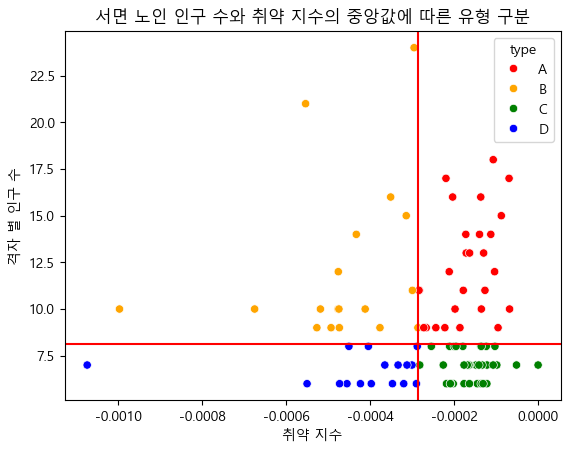

In [53]:
grid.loc[(grid["val_sum"] > silver_val_median) & (grid["diff_idx_sum"] > silver_idx_median), "type"] = "A"
grid.loc[(grid["val_sum"] > silver_val_median) & (grid["diff_idx_sum"] <= silver_idx_median), "type"] = "B"
grid.loc[(grid["val_sum"] <= silver_val_median) & (grid["diff_idx_sum"] > silver_idx_median), "type"] = "C"
grid.loc[(grid["val_sum"] <= silver_val_median) & (grid["diff_idx_sum"] <= silver_idx_median), "type"] = "D"

palette_colors = {"A": 'red', "B": 'orange', "C": 'green', "D": 'blue'}

import seaborn as sns
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams['axes.unicode_minus'] = False
sns.scatterplot(
    x="diff_idx_sum", 
    y="val_sum", 
    hue="type", 
    data=grid, 
    hue_order=["A", "B", "C", "D"],  # 범례 순서 지정
    palette=palette_colors  # 색상 지정
)
plt.axhline(y=silver_val_median+0.1, color="r")
plt.axvline(x=silver_idx_median, color="r")
plt.xlabel("취약 지수")
plt.ylabel("격자 별 인구 수")
plt.title(f"{hjd_name} 노인 인구 수와 취약 지수의 중앙값에 따른 유형 구분")

In [54]:
silver_.loc[(silver_["val"] > silver_val_median) & (silver_["diff_total_idx"] > silver_idx_median), "type"] = "A"
silver_.loc[(silver_["val"] > silver_val_median) & (silver_["diff_total_idx"] <= silver_idx_median), "type"] = "B"
silver_.loc[(silver_["val"] <= silver_val_median) & (silver_["diff_total_idx"] > silver_idx_median), "type"] = "C"
silver_.loc[(silver_["val"] <= silver_val_median) & (silver_["diff_total_idx"] <= silver_idx_median), "type"] = "D"

colors = {"A":'red', "B": 'orange', "C":'green', "D":'blue'}

legend_html = '''
<div style="
    position: fixed; 
    top: 20%; margin-top: 50px; left: 70%; margin-left: 20px; width: 160px; height: 120px; 
    border:2px solid grey; z-index:9999; font-size:14px;
    border:2px solid grey; z-index:9999; font-size:14px;
    background-color: white;
    opacity: 0.8;
    padding: 10px;
    ">
    <b>Legend</b> <br>
    <i style="background-color: red; width: 10px; height: 10px; display: inline-block;"></i> type A<br>
    <i style="background-color: orange; width: 10px; height: 10px; display: inline-block;"></i> type B<br>
    <i style="background-color: green; width: 10px; height: 10px; display: inline-block;"></i> type C<br>
    <i style="background-color: blue; width: 10px; height: 10px; display: inline-block;"></i> type D<br>
</div>
'''

m = folium.Map(
    location=[centroid_y.values[0], centroid_x.values[0]],
    zoom_start=14
    )
folium.TileLayer(
    tiles = "CartoDB positron", 
    # attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'
    ).add_to(m)

for name, lat, lng, type_ in zip(
    silver_["격자이름"], silver_["위도"], silver_["경도"], silver_["type"]):
    folium.CircleMarker([lat,lng],      # 원의 반지름
                        radius = 5,     # 원의 둘레 색상
                        color =colors[type_],
                        fill=True,
                        fill_color = colors[type_],  # 원을 채우는 색 
                        fill_opacity = 0.7,
                        popup = name,    
                        tootip = name, 
                        legend_name = "type_"  
           ).add_to(m)

# borderStyle로 투명도 및 선의 두께도 변경이 가능함
bordersStyle={
'color': '#9999FF',
'weight': 2,
'fillColor': '#9999FF',
'fillOpacit': 1
} 

folium.GeoJson(bnd_, name='json_data', style_function=lambda x:bordersStyle).add_to(m)
m.get_root().html.add_child(folium.Element(legend_html))
folium.map.LayerControl('topleft', collapsed= False).add_to(m)

m